# **Negative Dataset**

In [ ]:
## importing libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
## importing dataset
cvt_df = pd.read_csv("/content/drive/MyDrive/NLP_Project/Vaccine_Sentiments.csv", quotechar='"', delimiter=',', index_col = 0)
cvt_df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.



(159306, 16)

In [ ]:
ndf = cvt_df[(cvt_df["sentiment"] == 'Negative')]
ndf.shape

(30188, 16)

In [ ]:
! pip install vaderSentiment

In [ ]:
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words_list import stop_words_list
#from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
ndf.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703


In [ ]:
## tokenise string

ndf['tokenise'] = ndf.apply(lambda row: nltk.word_tokenize(row[13]), axis=1)
display(ndf.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci..."
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h..."
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ..."
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s..."
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w..."


In [ ]:
## initiate stopwords from nltk
stop_words = stopwords.words('english')

## add additional missing terms
stop_words.extend(stop_words_list) 
stop_words.extend(['johnson', 'johnson johnson', 'day', 'today', 'week', 'vaccinated', 'minister', 'arm', 'men']) 
## remove stopwords

ndf['remove_stopwords'] = ndf['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])
display(ndf.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci...","[true, damn, disappointing, climatecrisis, aus..."
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h...","[adjustment, disorder, symptoms, covid19irelan..."
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ...","[devil, advocate, russia, works, australian, m..."
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s...","[call, racist, wan, full, china, russia, coron..."
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w...","[joke, corona, positively]"


In [ ]:
## POS tagging

ndf["postags"] = ndf['remove_stopwords'].apply(lambda row: nltk.pos_tag(row))
display(ndf.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci...","[true, damn, disappointing, climatecrisis, aus...","[(true, JJ), (damn, NN), (disappointing, JJ), ..."
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h...","[adjustment, disorder, symptoms, covid19irelan...","[(adjustment, NN), (disorder, NN), (symptoms, ..."
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ...","[devil, advocate, russia, works, australian, m...","[(devil, JJ), (advocate, NN), (russia, NN), (w..."
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s...","[call, racist, wan, full, china, russia, coron...","[(call, NN), (racist, NN), (wan, IN), (full, J..."
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w...","[joke, corona, positively]","[(joke, NN), (corona, NN), (positively, RB)]"


In [ ]:
## extracting only nouns and verbs for effective topic modelling

def extract_words(row):
    postags = row["postags"]
    words = list()
    for word in postags:
      if (word[1] in ['NN', 'NNS', 'NNP', 'NNPS', 'UH', 'VB', 'VBG', 'VBD']):
        words.append(word[0])
    return words

ndf["req_words"] = ndf.apply(lambda row: extract_words(row), axis = 1)
display(ndf.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci...","[true, damn, disappointing, climatecrisis, aus...","[(true, JJ), (damn, NN), (disappointing, JJ), ...","[damn, climatecrisis, auspol]"
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h...","[adjustment, disorder, symptoms, covid19irelan...","[(adjustment, NN), (disorder, NN), (symptoms, ...","[adjustment, disorder, symptoms, covid__19]"
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ...","[devil, advocate, russia, works, australian, m...","[(devil, JJ), (advocate, NN), (russia, NN), (w...","[advocate, russia, media, tripping, write]"
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s...","[call, racist, wan, full, china, russia, coron...","[(call, NN), (racist, NN), (wan, IN), (full, J...","[call, racist, china, russia, coronavirusvaccine]"
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w...","[joke, corona, positively]","[(joke, NN), (corona, NN), (positively, RB)]","[joke, corona]"


In [ ]:
##  lemmatise words

wordnet_lemmatizer = WordNetLemmatizer()
ndf['lemmatise'] = ndf['req_words'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 
display(ndf.head(10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words,lemmatise
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci...","[true, damn, disappointing, climatecrisis, aus...","[(true, JJ), (damn, NN), (disappointing, JJ), ...","[damn, climatecrisis, auspol]","[damn, climatecrisis, auspol]"
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h...","[adjustment, disorder, symptoms, covid19irelan...","[(adjustment, NN), (disorder, NN), (symptoms, ...","[adjustment, disorder, symptoms, covid__19]","[adjustment, disorder, symptom, covid__19]"
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ...","[devil, advocate, russia, works, australian, m...","[(devil, JJ), (advocate, NN), (russia, NN), (w...","[advocate, russia, media, tripping, write]","[advocate, russia, medium, tripping, write]"
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s...","[call, racist, wan, full, china, russia, coron...","[(call, NN), (racist, NN), (wan, IN), (full, J...","[call, racist, china, russia, coronavirusvaccine]","[call, racist, china, russia, coronavirusvaccine]"
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w...","[joke, corona, positively]","[(joke, NN), (corona, NN), (positively, RB)]","[joke, corona]","[joke, corona]"
935,Paul Bianchi,United States,"Runner, husband, travel junkie, bridge player,...",11-09-2009 19:01,59.0,227.0,197.0,False,2020-12-08,Stephen Hahn is all that stands between us and...,['covidvaccine'],Twitter for iPad,False,stephen hahn is all that stands between us and...,Negative,-0.8176,"[stephen, hahn, is, all, that, stands, between...","[stephen, hahn, stands, disaster, allowed, hurt]","[(stephen, NN), (hahn, NN), (stands, VBZ), (di...","[stephen, hahn, disaster, allowed, hurt]","[stephen, hahn, disaster, allowed, hurt]"
936,"Antiqua N. Smart, DNP, NP-BC, PHNA-BC✝️ ⚕️",United States,APRN-CNP|Asst Professor @Loyola_NOLA|Entrepren...,27-12-2019 08:09,2663.0,1110.0,6676.0,False,2020-12-08,US Obesity Epidemic Could Undermine Effectiven...,NaN,Buffer,False,us obesity epidemic could undermine effectiven...,Negative,-0.2960,"[us, obesity, epidemic, could, undermine, effe...","[obesity, epidemic, undermine, effectiveness, 19]","[(obesity, NN), (epidemic, JJ), (undermine, JJ...","[obesity, effectiveness]","[obesity, effectiveness]"
938,Hudson Valley Lyomac,United States,Hudson Valley Lyoma

In [ ]:
## count vectorizer 

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
vectors = []

for index, row in ndf.iterrows():
    vectors.append(",".join(row[20]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised.shape)

(30188, 88798)


In [ ]:
## LDA Model

lda_model = LatentDirichletAllocation(n_components = 3, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

## column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

##  get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(ndf, df_document_topic, left_index = True, right_index = True, how = 'left')
display(df.head())
print(df.shape)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words,lemmatise,Topic1,Topic2,Topic3,Dominant_topic
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci...","[true, damn, disappointing, climatecrisis, aus...","[(true, JJ), (damn, NN), (disappointing, JJ), ...","[damn, climatecrisis, auspol]","[damn, climatecrisis, auspol]",0.11,0.11,0.78,3.0
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h...","[adjustment, disorder, symptoms, covid19irelan...","[(adjustment, NN), (disorder, NN), (symptoms, ...","[adjustment, disorder, symptoms, covid__19]","[adjustment, disorder, symptom, covid__19]",0.08,0.83,0.08,2.0
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ...","[devil, advocate, russia, works, australian, m...","[(devil, JJ), (advocate, NN), (russia, NN), (w...","[advocate, russia, media, tripping, write]","[advocate, russia, medium, tripping, write]",0.88,0.06,0.06,1.0
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s...","[call, racist, wan, full, china, russia, coron...","[(call, NN), (racist, NN), (wan, IN), (full, J...","[call, racist, china, russia, coronavirusvaccine]","[call, racist, china, russia, coronavirusvaccine]",0.94,0.03,0.03,1.0
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w...","[joke, corona, positively]","[(joke, NN), (corona, NN), (positively, RB)]","[joke, corona]","[joke, corona]",0.08,0.08,0.83,3.0


(30188, 25)


In [ ]:
## index names
docnames = ['Doc' + str(i) for i in range(len(ndf))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

## Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic + 1

## Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

## Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = [1, 2, 3]

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
100days distributed,1,1.332200
12months joined,2,1.332523
60minutes twitter,3,1.332383
_____________________________ fight,3,1.332383
_अन त_त,1,1.332435
...,...,...
𝙖𝙘𝙘𝙪𝙨𝙩𝙤𝙢𝙚𝙙 𝙡𝙞𝙛𝙚𝙨𝙩𝙮𝙡𝙚,1,1.332780
𝙝𝙚𝙖𝙙𝙞𝙣𝙜 𝙩𝙤𝙬𝙖𝙧𝙙𝙨,1,1.332780
𝙡𝙞𝙛𝙚𝙨𝙩𝙮𝙡𝙚 normalcy,1,1.332780
𝙤𝙛 restriction,1,1.332780


In [ ]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] 
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,1,[working vaccinate]
1,2,[side effect]
2,3,[cancer patient]


In [ ]:
ndf.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,sentiment,sentiment score,tokenise,remove_stopwords,postags,req_words,lemmatise
887,stevecolbran,Australia,"deep interest in wider world; nerd, bookish, e...",06-07-2017 06:50,248.0,1161.0,6271.0,False,2020-12-08,"So true, so damn disappointing...\n#CovidVacci...","['CovidVaccine', 'ClimateCrisis', 'auspol']",Twitter for iPhone,False,so true so damn disappointing covidvaccine vs ...,Negative,-0.6377,"[so, true, so, damn, disappointing, covidvacci...","[true, damn, disappointing, climatecrisis, aus...","[(true, JJ), (damn, NN), (disappointing, JJ), ...","[damn, climatecrisis, auspol]","[damn, climatecrisis, auspol]"
897,Born 4 Success,United Kingdom,"lifestyle Coach-Mental Health Nurse, Cognitive...",01-06-2020 15:07,484.0,669.0,4349.0,False,2020-12-08,Coronavirus Adjustment Disorder. Do you have t...,"['covid', 'COVID19', 'COVID19ireland', 'Covid1...",Twitter for iPhone,False,coronavirus adjustment disorder do you have th...,Negative,-0.4019,"[coronavirus, adjustment, disorder, do, you, h...","[adjustment, disorder, symptoms, covid19irelan...","[(adjustment, NN), (disorder, NN), (symptoms, ...","[adjustment, disorder, symptoms, covid__19]","[adjustment, disorder, symptom, covid__19]"
903,George Papdan,Australia,Websites for effective business,07-04-2009 02:53,48.0,126.0,929.0,False,2020-12-08,Devil's Advocate: Russia's #covidvaccine actua...,['covidvaccine'],Twitter for Android,False,devil s advocate russia s covidvaccine actuall...,Negative,-0.4019,"[devil, s, advocate, russia, s, covidvaccine, ...","[devil, advocate, russia, works, australian, m...","[(devil, JJ), (advocate, NN), (russia, NN), (w...","[advocate, russia, media, tripping, write]","[advocate, russia, medium, tripping, write]"
909,Rwitu Raj Gogoi,India,"part time thinker, part time asshole |\nReal i...",07-08-2020 18:34,9.0,108.0,20.0,False,2020-12-08,"Call me a racist but I just wanna say,\nIn a w...","['CoronavirusVaccine', 'CovidVaccine']",Twitter for Android,False,call me a racist but i just wanna say in a wor...,Negative,-0.3612,"[call, me, a, racist, but, i, just, wan, na, s...","[call, racist, wan, full, china, russia, coron...","[(call, NN), (racist, NN), (wan, IN), (full, J...","[call, racist, china, russia, coronavirusvaccine]","[call, racist, china, russia, coronavirusvaccine]"
924,☀️ Moj Lo🗯,Parallel Universe,Give me some Sunshine!,26-04-2010 07:02,409.0,465.0,2134.0,False,2020-12-08,I have a joke and n Corona but you will not ta...,"['COVID19', 'CovidVaccine']",Twitter for iPhone,False,i have a joke and n corona but you will not ta...,Negative,-0.4703,"[i, have, a, joke, and, n, corona, but, you, w...","[joke, corona, positively]","[(joke, NN), (corona, NN), (positively, RB)]","[joke, corona]","[joke, corona]"


In [ ]:
tpc1 = tmp[tmp['topic']==1]
tpc2 = tmp[tmp['topic']==2]
tpc3 = tmp[tmp['topic']==3]
#tpc4 = tmp[tmp['topic']==4]
#tpc5 = tmp[tmp['topic']==5]

In [ ]:
c_topic = tmp.groupby(['topic']).agg(['count']).reset_index()
c_topic.rename(columns={'relevance_score': ''}, inplace=True)
c_topic

,topic,
,,count
0,1,29013
1,2,29457
2,3,30328


<BarContainer object of 3 artists>

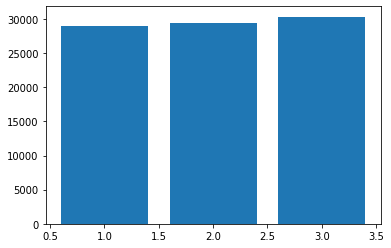

In [ ]:
plt.bar(c_topic.iloc[:,0], c_topic.iloc[:, 1])

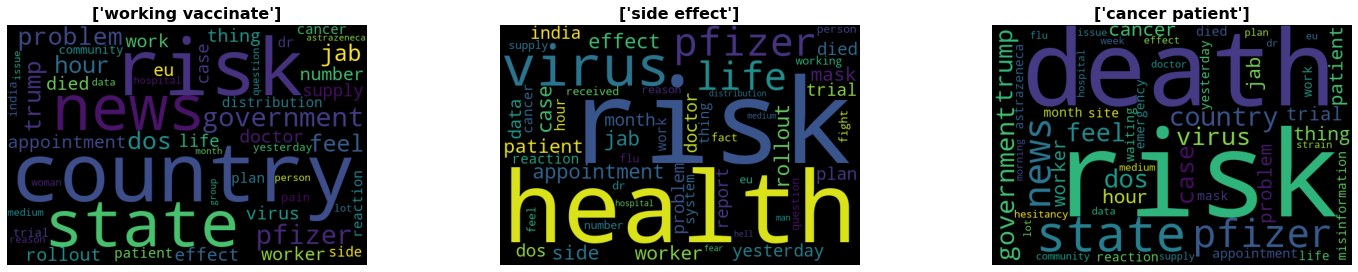

In [ ]:
## topicwise Wordclouds
from wordcloud import WordCloud

string1 = ','.join(list(str(m) for m in tpc1.index))
string2 = ','.join(list(str(m) for m in tpc2.index))
string3 = ','.join(list(str(m) for m in tpc3.index))
#string4 = ','.join(list(str(m) for m in tpc4.index))
#string5 = ','.join(list(str(m) for m in tpc5.index))

stop_words = ['people', 'vaccine', 'vaccination', 'today', 'day', 'time', 'going', 'vaccinated', 'do', 'year', 'state', 'postpone']
#s1 = ['people', 'vaccine', 'vaccination', 'today', 'day', 'time', 'going', 'vaccinated', 'do', 'year', 'state', 'health', 'postpone']
s1 = ['vaccination', 'vaccine', 'today', 'day', 'time', 'year', 'going', 'do', 'health', 'death']
s2 = ['vaccination', 'vaccine', 'today', 'day', 'year', 'time', 'going', 'do', 'death', 'trump', 'government', 'state', 'news', 'viru', 'country']
s3 = ['vaccination', 'vaccine', 'today', 'day', 'year', 'time', 'going', 'do', 'rollout', 'health']
w1 = WordCloud(width=600, height=400, max_words=50, contour_width=3, stopwords=s1, collocations = False).generate(string1)
w2 = WordCloud(width=600, height=400, max_words=50, contour_width=3, stopwords=s2, collocations = False).generate(string2)
w3 = WordCloud(width=600, height=400, max_words=50, contour_width=3, stopwords=s3, collocations = False).generate(string3)
#w4 = WordCloud(width=600, height=400, max_words=500, contour_width=3, stopwords = stop_words, collocations = False).generate(string4)
#w5 = WordCloud(width=600, height=400, max_words=500, contour_width=3, stopwords = stop_words, collocations = False).generate(string5)

plt.figure(figsize=(25,15))

plt.subplot(3,3,1)
t1 = all_topics.loc[all_topics['Dominant_topic'] == 1, 'topic_name'].iloc[0]
plt.title(t1,fontsize=16,fontweight='bold')
plt.imshow(w1)
plt.axis('off')

plt.subplot(3,3,2)
t2 = all_topics.loc[all_topics['Dominant_topic'] == 2, 'topic_name'].iloc[0]
plt.title(t2,fontsize=16,fontweight='bold')
plt.imshow(w2)
plt.axis('off')

plt.subplot(3,3,3)
t3 = all_topics.loc[all_topics['Dominant_topic'] == 3, 'topic_name'].iloc[0]
plt.title(t3,fontsize=16,fontweight='bold')
plt.imshow(w3)
plt.axis('off')
plt.savefig("/content/drive/MyDrive/NLP_Project/img12.jpg")

In [ ]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative
topic_name,
cancer patient,1283
side effect,1286
working vaccinate,1278
